In [1]:
# Import libraries
import os
import re   # for filter file

import gzip # for load .csv.gz file
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [2]:
%cd /content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code/Project
import mimic_utils as utils

# Project Path
PROJECT_PATH = '/content/drive/MyDrive/Yin_AutoEncoder/mimiciii_code/Project'
# Dataset set up
# mimic original dataset path
DATASET_PATH = os.path.join(PROJECT_PATH, '1.4')
PREPROCESS_DATA_PATH = os.path.join(PROJECT_PATH, 'preprocess')
# environment variables of BigQuery
PROJECT_ID = 'sepsis-mimic3'

/content/drive/.shortcut-targets-by-id/1z57lUhb4GSkXb08DWlFjx8kZ4Dg6Umsv/Yin_AutoEncoder/mimiciii_code/Project


# Identify Ventilation

Identify the presence of a mechanical ventilation base on mimic-iii/concepts/durations/[ventilation_classification.sql](https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/durations/ventilation_classification.sql)

Data is genereated from two table
1. chartevents for `carevue` Dataset
2. procedureevents_mv	for `metavision` Dataset

Aim to generated from 4 categorial ventilation event
1.  MechVent: case statement determining whether it is an instance of mech vent
2.  OxygenTherapy: initiation of oxygen therapy indicates **the ventilation has ended**
3.  Extubated
4.  SelfExtubated


In [ ]:
#
vent_query = """
  -- Identify The presence of a mechanical ventilation using settings
  select
    subject_id, hadm_id, icustay_id, charttime
    -- case statement determining whether it is an instance of mech vent
    , max(
      case
        when itemid is null or value is null then 0 -- can't have null values
        when itemid = 720 and value != 'Other/Remarks' THEN 1  -- VentTypeRecorded
        when itemid = 223848 and value != 'Other' THEN 1
        when itemid = 223849 then 1 -- ventilator mode
        when itemid = 467 and value = 'Ventilator' THEN 1 -- O2 delivery device == ventilator
        when itemid in
          (
          445, 448, 449, 450, 1340, 1486, 1600, 224687 -- minute volume
          , 639, 654, 681, 682, 683, 684,224685,224684,224686 -- tidal volume
          , 218,436,535,444,459,224697,224695,224696,224746,224747 -- High/Low/Peak/Mean/Neg insp force ("RespPressure")
          , 221,1,1211,1655,2000,226873,224738,224419,224750,227187 -- Insp pressure
          , 543 -- PlateauPressure
          , 5865,5866,224707,224709,224705,224706 -- APRV pressure
          , 60,437,505,506,686,220339,224700 -- PEEP
          , 3459 -- high pressure relief
          , 501,502,503,224702 -- PCV
          , 223,667,668,669,670,671,672 -- TCPCV
          , 224701 -- PSVlevel
          )
          THEN 1
        else 0
      end
      ) as MechVent
      , max(
        case
          -- initiation of oxygen therapy indicates the ventilation has ended
          when itemid = 226732 and value in
          (
            'Nasal cannula', -- 153714 observations
            'Face tent', -- 24601 observations
            'Aerosol-cool', -- 24560 observations
            'Trach mask ', -- 16435 observations
            'High flow neb', -- 10785 observations
            'Non-rebreather', -- 5182 observations
            'Venti mask ', -- 1947 observations
            'Medium conc mask ', -- 1888 observations
            'T-piece', -- 1135 observations
            'High flow nasal cannula', -- 925 observations
            'Ultrasonic neb', -- 9 observations
            'Vapomist' -- 3 observations
          ) then 1
          when itemid = 467 and value in
          (
            'Cannula', -- 278252 observations
            'Nasal Cannula', -- 248299 observations
            -- 'None', -- 95498 observations
            'Face Tent', -- 35766 observations
            'Aerosol-Cool', -- 33919 observations
            'Trach Mask', -- 32655 observations
            'Hi Flow Neb', -- 14070 observations
            'Non-Rebreather', -- 10856 observations
            'Venti Mask', -- 4279 observations
            'Medium Conc Mask', -- 2114 observations
            'Vapotherm', -- 1655 observations
            'T-Piece', -- 779 observations
            'Hood', -- 670 observations
            'Hut', -- 150 observations
            'TranstrachealCat', -- 78 observations
            'Heated Neb', -- 37 observations
            'Ultrasonic Neb' -- 2 observations
          ) then 1
        else 0
        end
      ) as OxygenTherapy
      , max(
        case when itemid is null or value is null then 0
          -- extubated indicates ventilation event has ended
          when itemid = 640 and value = 'Extubated' then 1
          when itemid = 640 and value = 'Self Extubation' then 1
        else 0
        end
        )
        as Extubated
      , max(
        case when itemid is null or value is null then 0
          when itemid = 640 and value = 'Self Extubation' then 1
        else 0
        end
        )
        as SelfExtubated
  from `physionet-data.mimiciii_clinical.chartevents` ce
  where ce.value is not null
  -- exclude rows marked as error
  and (ce.error != 1 or ce.error IS NULL)
  and itemid in
  (
      -- the below are settings used to indicate ventilation
        720, 223849 -- vent mode
      , 223848 -- vent type
      , 445, 448, 449, 450, 1340, 1486, 1600, 224687 -- minute volume
      , 639, 654, 681, 682, 683, 684,224685,224684,224686 -- tidal volume
      , 218,436,535,444,224697,224695,224696,224746,224747 -- High/Low/Peak/Mean ("RespPressure")
      , 221,1,1211,1655,2000,226873,224738,224419,224750,227187 -- Insp pressure
      , 543 -- PlateauPressure
      , 5865,5866,224707,224709,224705,224706 -- APRV pressure
      , 60,437,505,506,686,220339,224700 -- PEEP
      , 3459 -- high pressure relief
      , 501,502,503,224702 -- PCV
      , 223,667,668,669,670,671,672 -- TCPCV
      , 224701 -- PSVlevel

      -- the below are settings used to indicate extubation
      , 640 -- extubated

      -- the below indicate oxygen/NIV, i.e. the end of a mechanical vent event
      , 468 -- O2 Delivery Device#2
      , 469 -- O2 Delivery Mode
      , 470 -- O2 Flow (lpm)
      , 471 -- O2 Flow (lpm) #2
      , 227287 -- O2 Flow (additional cannula)
      , 226732 -- O2 Delivery Device(s)
      , 223834 -- O2 Flow

      -- used in both oxygen + vent calculation
      , 467 -- O2 Delivery Device
  )
  group by subject_id, hadm_id, icustay_id, charttime
  UNION DISTINCT
  -- add in the extubation flags from procedureevents_mv
  -- note that we only need the start time for the extubation
  -- (extubation is always charted as ending 1 minute after it started)
  select
    subject_id, hadm_id, icustay_id, starttime as charttime
    , 0 as MechVent
    , 0 as OxygenTherapy
    , 1 as Extubated
    , case when itemid = 225468 then 1 else 0 end as SelfExtubated
  from `physionet-data.mimiciii_clinical.procedureevents_mv`
  where itemid in
  (
    227194 -- "Extubation"
  , 225468 -- "Unplanned Extubation (patient-initiated)"
  , 225477 -- "Unplanned Extubation (non-patient initiated)"
  );
"""
# load query result
vent_df = utils.run_query(vent_query, PROJECT_ID)
print(vent_df.shape)

(2549354, 8)


In [ ]:
vent_df = vent_df[vent_df[['MechVent','OxygenTherapy', 'Extubated', 'SelfExtubated']].sum(axis=1) >0]
vent_df.nunique()

subject_id         37377
hadm_id            46291
icustay_id         49223
charttime        1273782
MechVent               2
OxygenTherapy          2
Extubated              2
SelfExtubated          2
dtype: int64

In [ ]:
vent_agg = vent_df.groupby('hadm_id').agg({'icustay_id':'nunique',
                                'MechVent':'sum',
                                'OxygenTherapy':'sum',
                                'Extubated':'sum',
                                'SelfExtubated':'sum',})
print(vent_agg.shape[0],
      vent_agg[vent_agg['MechVent']>0].shape[0],
      vent_agg[vent_agg['OxygenTherapy']>0].shape[0],
      vent_agg[vent_agg['Extubated']>0].shape[0]) # count OT> MV > Extubated

51031 26807 42620 15315


## Samples

### normal (Contains MV)


In [ ]:
vent_agg[(vent_agg['MechVent']>0) & ((vent_agg['OxygenTherapy']>0) & (vent_agg['Extubated']>2))].head(30)

,icustay_id,MechVent,OxygenTherapy,Extubated,SelfExtubated
hadm_id,,,,,
100286,1,21,18,3,0
100406,2,32,23,3,2
100749,1,191,43,3,0
100753,1,88,8,3,0
101018,3,201,58,3,0
101020,2,298,127,3,1
101250,1,87,87,3,0
101974,4,38,94,3,0
102103,1,78,40,3,0


In [ ]:
with pd.ExcelWriter('output.xlsx') as writer:
    vent_df[vent_df['hadm_id'] == 100286].sort_values(['hadm_id', 'charttime']).to_excel(writer, sheet_name='id100286')
    vent_df[vent_df['hadm_id'] == 105694].sort_values(['hadm_id', 'charttime']).to_excel(writer, sheet_name='id105694')

In [ ]:
# MV->Extubated->OxygenTherapy
print(vent_agg[(vent_agg['MechVent']>0) & ((vent_agg['OxygenTherapy']>0) & (vent_agg['Extubated']>0))].shape)
vent_df[vent_df['hadm_id'] == 100024].sort_values(['hadm_id', 'charttime'])

(14299, 5)


,subject_id,hadm_id,icustay_id,charttime,MechVent,OxygenTherapy,Extubated,SelfExtubated
1074538,77221,100024,201668,2170-09-19 17:00:00,1,0,0,0
96466,77221,100024,201668,2170-09-19 19:35:00,1,0,0,0
216820,77221,100024,201668,2170-09-19 20:00:00,1,0,0,0
741743,77221,100024,201668,2170-09-19 20:07:00,1,0,0,0
249748,77221,100024,201668,2170-09-19 21:00:00,1,0,0,0
647853,77221,100024,201668,2170-09-19 22:00:00,0,0,1,0
913613,77221,100024,201668,2170-09-19 22:00:00,0,1,0,0
336504,77221,100024,201668,2170-09-20 01:00:00,0,1,0,0
2336270,77221,100024,201668,2170-09-20 04:22:00,0,1,0,0
454562,77221,100024,201668,2170-09-20 08:00:00,0,1,0,0


In [ ]:
# MV->Ext
print(vent_agg[(vent_agg['MechVent']>0) & ((vent_agg['OxygenTherapy']==0) & (vent_agg['Extubated']>0))].shape)
vent_df[vent_df['hadm_id'] == 199242].sort_values(['hadm_id', 'charttime'])

(949, 5)


,subject_id,hadm_id,icustay_id,charttime,MechVent,OxygenTherapy,Extubated,SelfExtubated
614547,4015,199242,267820,2166-08-06 20:30:00,1,0,0,0
1147968,4015,199242,267820,2166-08-06 23:00:00,1,0,0,0
207063,4015,199242,267820,2166-08-07 07:13:00,1,0,0,0
1334121,4015,199242,267820,2166-08-07 11:20:00,1,0,0,0
1327179,4015,199242,267820,2166-08-07 13:30:00,1,0,0,0
187120,4015,199242,267820,2166-08-07 16:30:00,0,0,1,0


In [ ]:
# MV->OxygenTherapy
df = vent_agg[(vent_agg['MechVent']>0) & ((vent_agg['OxygenTherapy']>0) & (vent_agg['Extubated']==0))]
print(df.shape)
vent_df[vent_df['hadm_id'] == 199971].sort_values(['hadm_id', 'charttime']).head(6)

(8843, 5)


,subject_id,hadm_id,icustay_id,charttime,MechVent,OxygenTherapy,Extubated,SelfExtubated
299959,5348,199971,259693,2171-12-09 14:25:00,1,0,0,0
567638,5348,199971,259693,2171-12-09 18:47:00,1,0,0,0
2507053,5348,199971,259693,2171-12-09 19:35:00,1,0,0,0
1151710,5348,199971,259693,2171-12-09 20:50:00,1,0,0,0
2236044,5348,199971,259693,2171-12-09 22:00:00,0,1,0,0
1629193,5348,199971,259693,2171-12-10 00:00:00,0,1,0,0


In [ ]:
# MV
df = vent_agg[(vent_agg['MechVent']>0) & ((vent_agg['OxygenTherapy']==0) & (vent_agg['Extubated']==0))]
print(df.shape)
# vent_df[vent_df['hadm_id'] == 199844].sort_values(['hadm_id', 'charttime'])

(2716, 5)


In [ ]:
vent_agg[(vent_agg['MechVent']>0)].shape

(26807, 5)

### unreasonable data（Ext +； MV -）

In [ ]:
# Extubated
df = vent_agg[(vent_agg['MechVent']==0) & ((vent_agg['OxygenTherapy']==0) & (vent_agg['Extubated']>0))]
print(df.shape)
vent_df[vent_df['hadm_id'] == 197513].sort_values(['hadm_id', 'charttime'])

(6, 5)


,subject_id,hadm_id,icustay_id,charttime,MechVent,OxygenTherapy,Extubated,SelfExtubated
2145223,57460,197513,288565,2165-01-16 15:10:00,0,0,1,0
647507,57460,197513,288565,2165-01-16 16:50:00,0,0,1,0


In [ ]:
# OxygenTherapy->Ext
print(vent_agg[(vent_agg['MechVent']==0) & ((vent_agg['OxygenTherapy']>0) & (vent_agg['Extubated']>0))].shape)
vent_df[vent_df['hadm_id'] == 107891].sort_values(['hadm_id', 'charttime'])

(61, 5)


,subject_id,hadm_id,icustay_id,charttime,MechVent,OxygenTherapy,Extubated,SelfExtubated
2119342,92135,107891,286756,2163-03-27 10:00:00,0,1,0,0
2145256,92135,107891,286756,2163-03-27 10:30:00,0,0,1,0
1378349,92135,107891,286756,2163-03-27 11:00:00,0,1,0,0
859829,92135,107891,286756,2163-03-27 12:03:00,0,1,0,0
2341020,92135,107891,286756,2163-03-27 13:00:00,0,1,0,0
2030391,92135,107891,286756,2163-03-27 14:00:00,0,1,0,0


### rest (only OT)

In [ ]:
# OxygenTherapy
df = vent_agg[(vent_agg['MechVent']==0) & ((vent_agg['OxygenTherapy']>0) & (vent_agg['Extubated']==0))]
print(df.shape)
# vent_df[vent_df['hadm_id'] == 107891].sort_values(['hadm_id', 'charttime'])

(19417, 5)


### Counts

In [ ]:
nor = 14299+949+8843+2716 # with mV
not_nor = 6+61 # E, OT+E
other = 19417 #OT
nor, not_nor, other, nor+not_nor+other #num of hadm ids

(26807, 67, 19417, 46291)

## Extubation Ducumentation

In [ ]:
item_path= os.path.join(DATASET_PATH, 'D_ITEMS.csv.gz')
item_df = utils.load_df(item_path)
# display(item_df.head())
item_df[item_df.ITEMID.isin([640
                            # 640 with value='Extubation'      #label as Extubation
                            # 640 with value='Self Extubation' #label Extubation and SelfExtubated
                             , 227194  #label as Extubation
                             , 225468  #label as Extubation and SelfExtubated
                             , 225477  #label as Extubation
                            ])]

,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
ROW_ID,,,,,,,,,
593,640,Significant Events,NaN,carevue,chartevents,NaN,NaN,NaN,NaN
14605,227194,Extubation,Extubation,metavision,procedureevents_mv,1-Intubation/Extubation,None,Process,NaN
13928,225468,Unplanned Extubation (patient-initiated),Unplanned Extubation (patient-initiated),metavision,procedureevents_mv,1-Intubation/Extubation,None,Process,NaN
13935,225477,Unplanned Extubation (non-patient initiated),Unplanned Extubation (non-patient initiated),metavision,procedureevents_mv,1-Intubation/Extubation,None,Process,NaN


In [ ]:
cv_extubation = utils.run_query(
    """
    SELECT *
    FROM `physionet-data.mimiciii_clinical.chartevents`
    WHERE itemid = 640
    """, PROJECT_ID)
print('Overall Summary for Extubation in Chartevents')
display(item_df[item_df.ITEMID==640])
print("\nAll the unique value for Significant Events(itemid=640)\n", cv_extubation['VALUE'].unique())

print('\nExtubated Samples')
display(cv_extubation[cv_extubation['VALUE']=='Extubated'].head(1))
display(cv_extubation[cv_extubation['VALUE']=='Self Extubation'].head(1))

Overall Summary for Extubation in Chartevents


,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
ROW_ID,,,,,,,,,
593,640,Significant Events,NaN,carevue,chartevents,NaN,NaN,NaN,NaN



All the unique value for Significant Events(itemid=640)
 ['Cardiac Arrest' 'Defibrillation' 'Self Extubation' 'Chest Opened'
 'Trach Changed' 'Pacer External' 'NeuroAcuteChange' 'Resp Arrest'
 'Pneumothorax' 'Tamponade' 'Retroper Bleed' None 'OR Sent' 'Extubated'
 'Intubated' 'Chest Pain' 'Dysrhythmia' 'Fluid Bolus' 'OR Received'
 'Cardioversion' 'Other/Remarks' 'Resp Distress']

Extubated Samples


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
15440,163223006,25609,192819,239683,640,2117-03-16 07:00:00,2117-03-16 07:27:00,21570,Extubated,NaN,None,<NA>,<NA>,None,NotStopd


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
4,191548875,32441,172750,222212,640,2180-06-03 18:30:00,2180-06-03 19:14:00,20962,Self Extubation,NaN,None,<NA>,<NA>,None,NotStopd


# MIT ventilation duration
sorce [link](https://github.com/MIT-LCP/mimic-code/blob/main/mimic-iii/concepts/durations/ventilation_durations.sql)

count    25953.000000
mean         4.577159
std          8.134002
min          0.000000
25%          1.000000
50%          1.000000
75%          5.000000
max        185.000000
Name: duration_days, dtype: float64

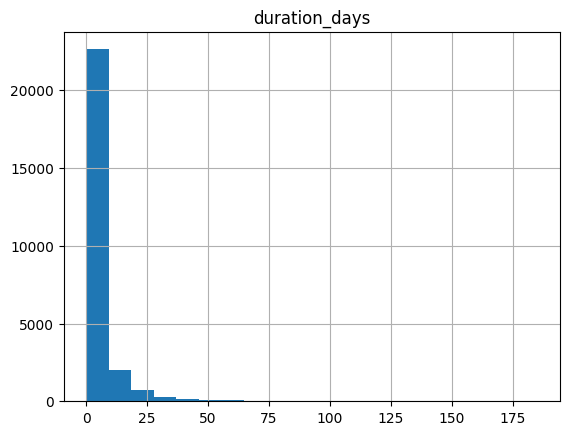

In [ ]:
# load vent duration table
vent_dur_df = utils.run_query(
    """
    SELECT *
    FROM `physionet-data.mimiciii_derived.ventilation_durations`
    """, PROJECT_ID)

# assign Hadm id
# Check if the file exists
demog_path = os.path.join(PREPROCESS_DATA_PATH, "demographics.csv")
if os.path.exists(demog_path):
    # Load the CSV file into a DataFrame
    demog_df = pd.read_csv(demog_path, index_col=0)
else:
    # Query demographics information by using BigQuery
    demog_df = utils.demog_sql2df(PROJECT_ID, saved_path=PREPROCESS_DATA_PATH)
ids_df = demog_df[['subject_id','hadm_id', 'icustay_id']]
vent_dur_df.dropna(subset=['icustay_id'], inplace=True)
vent_dur_df = ids_df.merge(vent_dur_df, on='icustay_id')
# report
vent_dur_count = vent_dur_df.groupby('hadm_id').duration_hours.sum().reset_index()
vent_dur_count['duration_days'] = (vent_dur_count['duration_hours'] +23) // 24 # ceiling int divide
vent_dur_count.hist('duration_days', bins=20)
vent_dur_count.duration_days.describe()

# Ventilation Day Count

In [ ]:
def Identify_ventilation(project_id):
  vent_query = """
  -- Identify The presence of a mechanical ventilation using settings
  select
    subject_id, hadm_id, icustay_id, charttime
    -- case statement determining whether it is an instance of mech vent
    , max(
      case
        when itemid is null or value is null then 0 -- can't have null values
        when itemid = 720 and value != 'Other/Remarks' THEN 1  -- VentTypeRecorded
        when itemid = 223848 and value != 'Other' THEN 1
        when itemid = 223849 then 1 -- ventilator mode
        when itemid = 467 and value = 'Ventilator' THEN 1 -- O2 delivery device == ventilator
        when itemid in
          (
          445, 448, 449, 450, 1340, 1486, 1600, 224687 -- minute volume
          , 639, 654, 681, 682, 683, 684,224685,224684,224686 -- tidal volume
          , 218,436,535,444,459,224697,224695,224696,224746,224747 -- High/Low/Peak/Mean/Neg insp force ("RespPressure")
          , 221,1,1211,1655,2000,226873,224738,224419,224750,227187 -- Insp pressure
          , 543 -- PlateauPressure
          , 5865,5866,224707,224709,224705,224706 -- APRV pressure
          , 60,437,505,506,686,220339,224700 -- PEEP
          , 3459 -- high pressure relief
          , 501,502,503,224702 -- PCV
          , 223,667,668,669,670,671,672 -- TCPCV
          , 224701 -- PSVlevel
          )
          THEN 1
        else 0
      end
      ) as MechVent
      , max(
        case
          -- initiation of oxygen therapy indicates the ventilation has ended
          when itemid = 226732 and value in
          (
            'Nasal cannula', -- 153714 observations
            'Face tent', -- 24601 observations
            'Aerosol-cool', -- 24560 observations
            'Trach mask ', -- 16435 observations
            'High flow neb', -- 10785 observations
            'Non-rebreather', -- 5182 observations
            'Venti mask ', -- 1947 observations
            'Medium conc mask ', -- 1888 observations
            'T-piece', -- 1135 observations
            'High flow nasal cannula', -- 925 observations
            'Ultrasonic neb', -- 9 observations
            'Vapomist' -- 3 observations
          ) then 1
          when itemid = 467 and value in
          (
            'Cannula', -- 278252 observations
            'Nasal Cannula', -- 248299 observations
            -- 'None', -- 95498 observations
            'Face Tent', -- 35766 observations
            'Aerosol-Cool', -- 33919 observations
            'Trach Mask', -- 32655 observations
            'Hi Flow Neb', -- 14070 observations
            'Non-Rebreather', -- 10856 observations
            'Venti Mask', -- 4279 observations
            'Medium Conc Mask', -- 2114 observations
            'Vapotherm', -- 1655 observations
            'T-Piece', -- 779 observations
            'Hood', -- 670 observations
            'Hut', -- 150 observations
            'TranstrachealCat', -- 78 observations
            'Heated Neb', -- 37 observations
            'Ultrasonic Neb' -- 2 observations
          ) then 1
        else 0
        end
      ) as OxygenTherapy
      , max(
        case when itemid is null or value is null then 0
          -- extubated indicates ventilation event has ended
          when itemid = 640 and value = 'Extubated' then 1
          when itemid = 640 and value = 'Self Extubation' then 1
        else 0
        end
        )
        as Extubated
      , max(
        case when itemid is null or value is null then 0
          when itemid = 640 and value = 'Self Extubation' then 1
        else 0
        end
        )
        as SelfExtubated
  from `physionet-data.mimiciii_clinical.chartevents` ce
  where ce.value is not null
  -- exclude rows marked as error
  and (ce.error != 1 or ce.error IS NULL)
  and itemid in
  (
      -- the below are settings used to indicate ventilation
        720, 223849 -- vent mode
      , 223848 -- vent type
      , 445, 448, 449, 450, 1340, 1486, 1600, 224687 -- minute volume
      , 639, 654, 681, 682, 683, 684,224685,224684,224686 -- tidal volume
      , 218,436,535,444,224697,224695,224696,224746,224747 -- High/Low/Peak/Mean ("RespPressure")
      , 221,1,1211,1655,2000,226873,224738,224419,224750,227187 -- Insp pressure
      , 543 -- PlateauPressure
      , 5865,5866,224707,224709,224705,224706 -- APRV pressure
      , 60,437,505,506,686,220339,224700 -- PEEP
      , 3459 -- high pressure relief
      , 501,502,503,224702 -- PCV
      , 223,667,668,669,670,671,672 -- TCPCV
      , 224701 -- PSVlevel

      -- the below are settings used to indicate extubation
      , 640 -- extubated

      -- the below indicate oxygen/NIV, i.e. the end of a mechanical vent event
      , 468 -- O2 Delivery Device#2
      , 469 -- O2 Delivery Mode
      , 470 -- O2 Flow (lpm)
      , 471 -- O2 Flow (lpm) #2
      , 227287 -- O2 Flow (additional cannula)
      , 226732 -- O2 Delivery Device(s)
      , 223834 -- O2 Flow

      -- used in both oxygen + vent calculation
      , 467 -- O2 Delivery Device
  )
  group by subject_id, hadm_id, icustay_id, charttime
  UNION DISTINCT
  -- add in the extubation flags from procedureevents_mv
  -- note that we only need the start time for the extubation
  -- (extubation is always charted as ending 1 minute after it started)
  select
    subject_id, hadm_id, icustay_id, starttime as charttime
    , 0 as MechVent
    , 0 as OxygenTherapy
    , 1 as Extubated
    , case when itemid = 225468 then 1 else 0 end as SelfExtubated
  from `physionet-data.mimiciii_clinical.procedureevents_mv`
  where itemid in
  (
    227194 -- "Extubation"
  , 225468 -- "Unplanned Extubation (patient-initiated)"
  , 225477 -- "Unplanned Extubation (non-patient initiated)"
  );
  """
  # load query result
  vent_df = utils.run_query(vent_query, project_id)
  return vent_df
# vent_df = Identify_ventilation(PROJECT_ID)

In [ ]:
def ventilation_day_count(project_id, vent_type=['MechVent','OxygenTherapy','Extubated','SelfExtubated']):
  '''
  Identify The presence of a mechanical ventilation
  and
  Compute the num of day the patient(HADM_ID) was receiving mechanical ventilation,
      - regardless of how many hours in that day the patient received ventilation

  project_id: BigQuery Mimic III Project id
  vent_type: a sebset of 4 ventalation type ['MechVent','OxygenTherapy','Extubated','SelfExtubated'].
             this function only count the ventalation type with in this subset
             by default all 4 tpye will be includes, however,
  '''
  # Identify the presence of a mechanical ventilation using settings
  vent_df = Identify_ventilation(project_id)
  # Select qualified ventalation event according to vent_type
  vent_df['sum'] = vent_df[vent_type].sum(axis=1)
  qualified_vent_df = vent_df[vent_df['sum']>0]
  numevent = qualified_vent_df.shape[0]
  # get date
  qualified_vent_df['date_count'] = pd.to_datetime(qualified_vent_df['charttime']).dt.date
  vent_day_df = qualified_vent_df[['hadm_id', 'date_count']].drop_duplicates()
  # count ventilation days: if a pacient get ventilation (regaless of specific hours), then +1
  vent_day_count = vent_day_df.groupby('hadm_id').date_count.count().reset_index()
  return vent_day_count

# Summary

In [3]:
import mimiciii_icu_trauma_patient_cohort as trauma_cohort
# get ventilation day table
vent_path = os.path.join(PREPROCESS_DATA_PATH, "ventilation_day_MV.csv")
if os.path.exists(vent_path):
    vent_df = pd.read_csv(vent_path, index_col=0)
else:
    vent_df = trauma_cohort.ventilation_day_count(PROJECT_ID, vent_type=['MechVent'])
    vent_df.to_csv(vent_path)

count    46291.000000
mean         5.542373
std          8.826473
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        262.000000
Name: date_count, dtype: float64

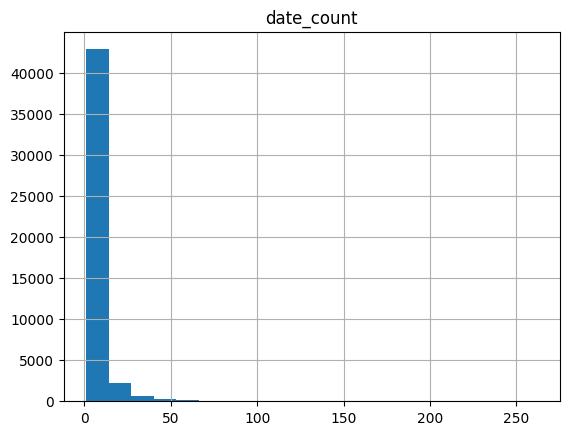

In [ ]:
# If we count all 4 type of ventilation
vent_day_count = ventilation_day_count(PROJECT_ID, vent_type=['MechVent','OxygenTherapy','Extubated','SelfExtubated'])
vent_day_count.shape #46291
vent_day_count.hist('date_count', bins=20)
vent_day_count.date_count.describe()

<ipython-input-14-29b789aabc86>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified_vent_df['date_count'] = pd.to_datetime(qualified_vent_df['charttime']).dt.date


count    26807.000000
mean         5.283806
std          8.596492
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        227.000000
Name: date_count, dtype: float64

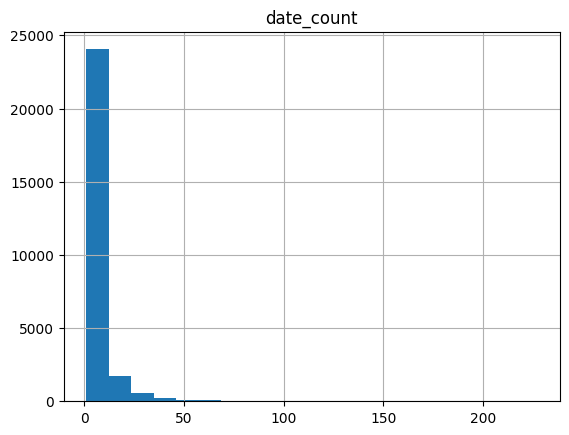

In [ ]:
vent_day_count = ventilation_day_count(PROJECT_ID, vent_type=['MechVent'])
vent_day_count.shape
vent_day_count.hist('date_count', bins=20)
vent_day_count.date_count.describe()

count    26807.000000
mean         5.283806
std          8.596492
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        227.000000
Name: date_count, dtype: float64

array([[<Axes: title={'center': 'date_count'}>]], dtype=object)

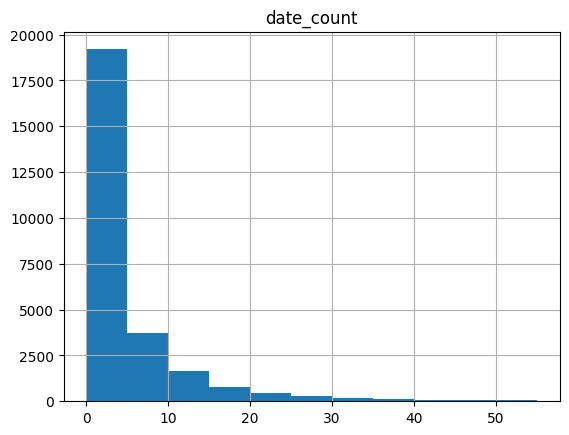

In [11]:
display(vent_df.date_count.describe())
vent_df.hist('date_count', bins=np.arange(0,60,5))

array([[<Axes: title={'center': 'date_count'}>]], dtype=object)

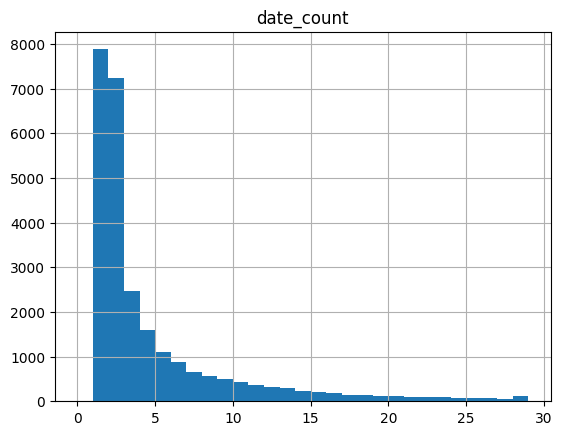

In [15]:
vent_df.hist('date_count', bins=np.arange(0, 30, 1))

# HMC Data comparison